In [16]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import os
import pickle

#### This notebook demonstrates how to load and visualize Regions of Interest (ROIs) for version B MNI152 space. ROIs defined for  version B MNI152 space contain the same 22 ROIs as in version A, plus MT, and each ROI is divided into left and right hemisphere (for a total of 46 ROIs). Additionally, version B MNI152 space defines a "BMDgeneral" ROI, inspired by the Natural Scene Dataset's NSDgeneral ROI. BMDgeneral reflects the brain regions that consistently respond to BMD's 3s stimuli across all 10 subjects. It is algorithmically defined based on each subject's splithalf reliability between splits of all 1,102 stimuli. Note the exact procedure of defining the ROIs differs slightly between versionA and versionB. See the main manuscript and supplementary discussion for more information on ROI definitions.

In [17]:
dataset_root = "/your/path/to/BOLDMomentsDataset"
fmri_path = os.path.join(dataset_root, "derivatives","versionB", "MNI152", "GLM")
subject = "sub-01" #representative subject. subjects only differ in their categorically selective ROIs
#load the group mask
group_mask_nii = nib.load(os.path.join(fmri_path, "mask", "groupMask_space-MNI152.nii"))

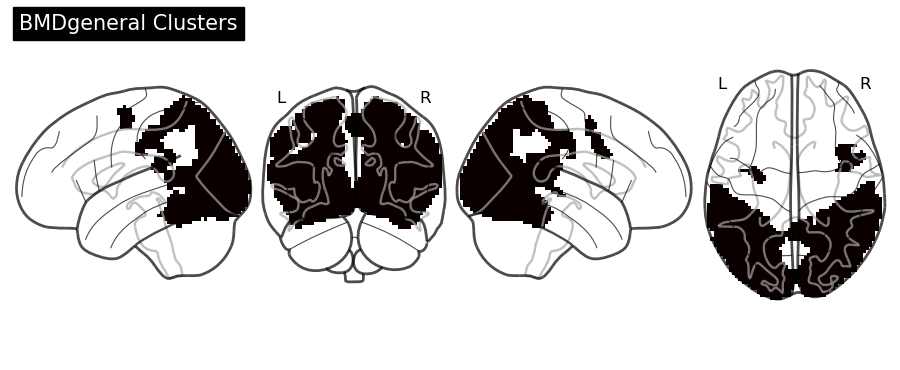

In [18]:
#plot BMDgeneral. This is exactly the same for each subject
with open(os.path.join(fmri_path, "parcels", "group_parcels", "parcel-BMDgeneral_indices.pkl"), 'rb') as f:
    roi_data = pickle.load(f)
indices_3d = roi_data[0]
bmdgeneral = np.zeros(group_mask_nii.shape)
bmdgeneral[indices_3d[:,0],indices_3d[:,1],indices_3d[:,2]] = 1
bmdgeneral_nii = nib.Nifti1Image(bmdgeneral, affine=group_mask_nii.affine)
plotting.plot_glass_brain(
    bmdgeneral_nii,
    title=f'BMDgeneral Clusters',
    display_mode="lyrz",
    colorbar=False,
    threshold=0,
    )

#### The 46 ROIs in version B MNI152 space all have the same number of voxels across subjects. The eight (sixteen) categorically selective ROIs that were defined using each subject's functional localizer contrasts (left and right 'EBA','OFA','STS','RSC','FFA','LOC', 'PPA', 'TOS') differ in the exact voxel indices between subjects but still have the same number of voxels. For example, ROI "rV1v" is defined as the exact same 170 voxels for each subject, but ROI "rEBA" is defined as each subject's most responsive 116 voxels. If you would like to use categorically selective ROIs that are also exactly the same in each subject (e.g., if spatial relationship between voxels matters in an analysis), then the group parcels in ./derivatives/versionB/MNI152/GLM/parcels/group_parcels may be of interest. Maintaining the same number of voxels in each ROI across subjects was primarily done to facilitate cross-subject modeling approaches where such consistency might help a lot (e.g., keeping a model layer size the same across subjects).

In [19]:
Groups = {'group1': ['V1v','V2v','V3v','hV4','EBA','OFA','STS','RSC'],
          'group2': ['V1d','V2d','V3d','FFA','LOC', 'PPA', 'TOS'],
          'group3': ['V3ab', 'IPS0', 'IPS1-2-3','7AL','BA2','PFt','PFop','MT']}
Groups_colors = {'group1': (0, len(Groups['group1'])),
                 'group2': (len(Groups['group1']), len(Groups['group1'])+len(Groups['group2'])),
                 'group3': (len(Groups['group1'])+len(Groups['group2']), len(Groups['group1'])+len(Groups['group2'])+len(Groups['group3']))}
Groups_cmaps = {'group1': 'Set1',
                'group2': 'Set2',
                'group3': 'Set3'}

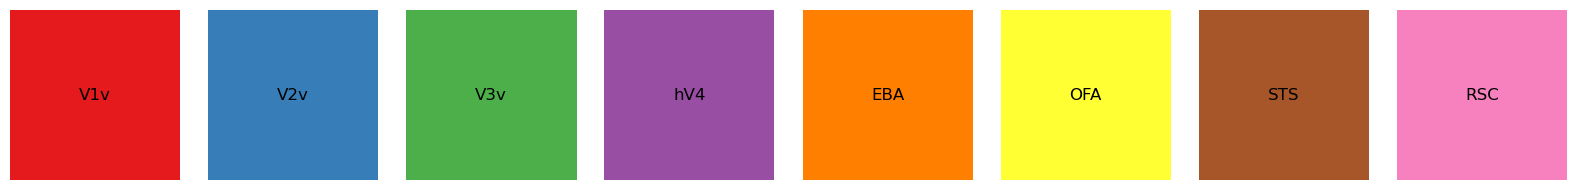

/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(


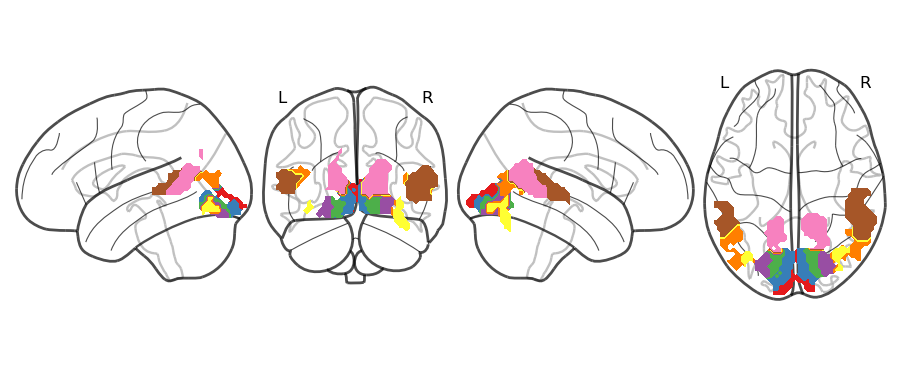

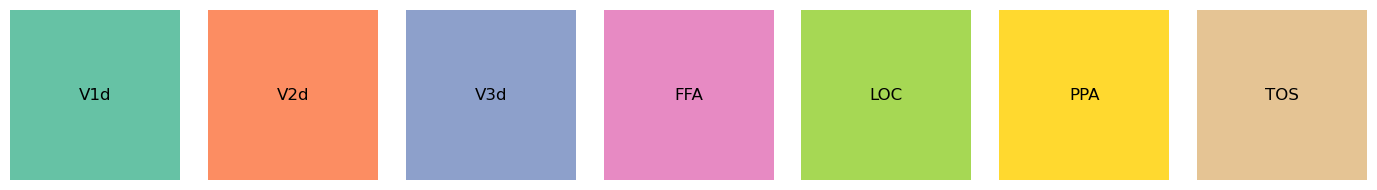

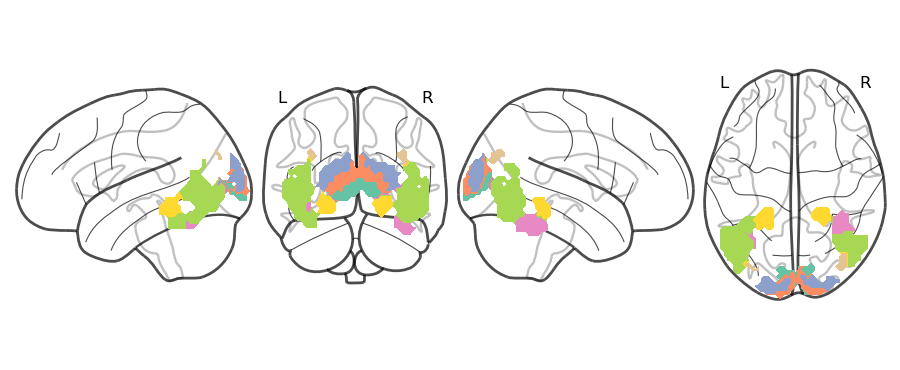

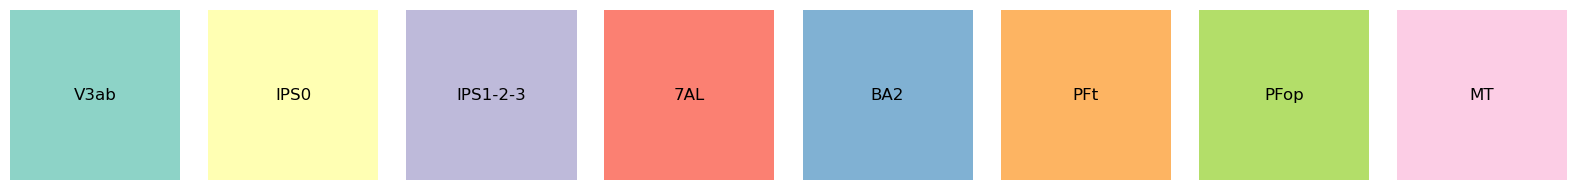

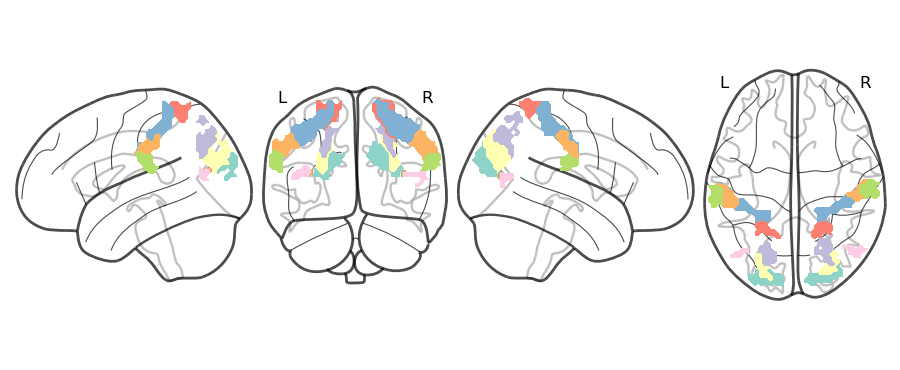

In [20]:
group_offset = 0
for key, rois in Groups.items():
    #create a colormap 
    cmapAccent = plt.get_cmap(Groups_cmaps[key])
    cmapFinal = [cmapAccent(i) for i in range(len(rois))]

    fig, axs = plt.subplots(1, len(cmapFinal), figsize=(len(cmapFinal) * 2, 2), sharex=True, sharey=True)
    for count, color in enumerate(cmapFinal):
        axs[count].imshow([[cmapFinal[count]]])
        axs[count].text(0.5, 0.5, rois[count], color='black', fontsize=12,
                ha='center', va='center', transform=axs[count].transAxes)
        axs[count].axis('off')  # Hide the axes
    plt.tight_layout()
    plt.show()

    numROIs_low = Groups_colors[key][0]
    numROIs_high = Groups_colors[key][1]
    roi_volume = np.zeros(group_mask_nii.shape)
    #load ROIs
    for count, roi in enumerate(rois):
        for hemi in ['l','r']:
            # roi_data[0] contains the voxel indices in the 3D volume
            # roi_data[1] contains voxel indices wrt to a 2D array of the flattened group mask
            # roi_data[2] contains the group mask nii file for convenience
            with open(os.path.join(fmri_path, subject, "ROIs", f"ROI-{hemi}{roi}_indices.pkl"), 'rb') as f:
                roi_data = pickle.load(f) 
            indices_3d = roi_data[0]
            roi_volume[indices_3d[:,0],indices_3d[:,1],indices_3d[:,2]] = count+1+group_offset
    roi_volume_nii = nib.Nifti1Image(roi_volume, group_mask_nii.affine)
    levels = list(np.array(range(group_offset, len(rois)+1+group_offset))+0.5)

    display = plotting.plot_glass_brain(None, plot_abs=False, display_mode='lyrz')
    display.add_contours(roi_volume_nii, levels=levels, colors=cmapFinal,
                     linewidths=0, filled=True)
    plt.show()
    group_offset += len(rois)